In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, hamming_loss, accuracy_score

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Configuration constants for BERT fine-tuning
MODEL_NAME = 'bert-base-uncased'      # Pre-trained BERT model identifier (uncased variant)
MAX_LENGTH = 128                     # Maximum token length for input sequences (truncation/padding)
BATCH_SIZE = 16                      # Number of samples per training batch
EPOCHS = 3                           # Number of training epochs (full dataset iterations)
LEARNING_RATE = 2e-5                 # Learning rate for optimizer (fine-tuning)

In [ ]:
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset files not found. Please check the input path.")
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("\nTrain Data Head:")
print(train_df.head())
print("\nTest Data Head:")
print(test_df.head())

Data loaded successfully.
Train Data Shape: (159571, 8)
Test Data Shape: (153164, 2)

Train Data Head:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Test Data Head:
                 id                          

In [ ]:
label_counts = train_df[label_cols].sum()
label_percentages = (label_counts / len(train_df)) * 100

In [ ]:
label_stats_df = pd.DataFrame({'count': label_counts, 'percentage': label_percentages})
print("Label Distribution:")
print(label_stats_df)


Label Distribution:
               count  percentage
toxic          15294    9.584448
severe_toxic    1595    0.999555
obscene         8449    5.294822
threat           478    0.299553
insult          7877    4.936361
identity_hate   1405    0.880486


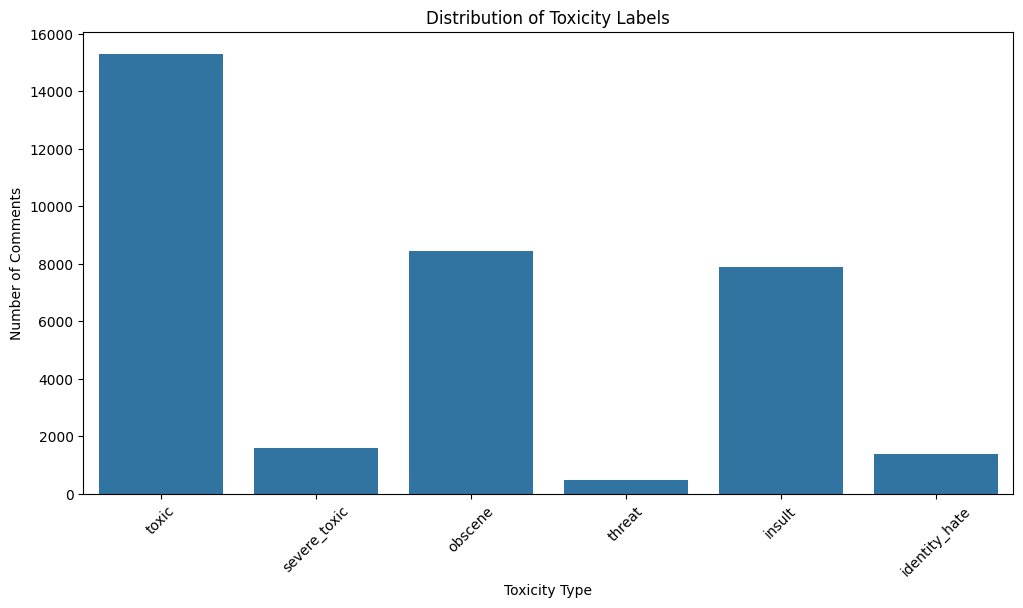

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=label_stats_df.index, y=label_stats_df['count'])
plt.title('Distribution of Toxicity Labels')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# checking for clean comments
no_label_count = len(train_df[train_df[label_cols].sum(axis=1) == 0])
print(f"\nNumber of comments with NO toxicity labels: {no_label_count} ({no_label_count / len(train_df) * 100:.2f}%)")



Number of comments with NO toxicity labels: 143346 (89.83%)


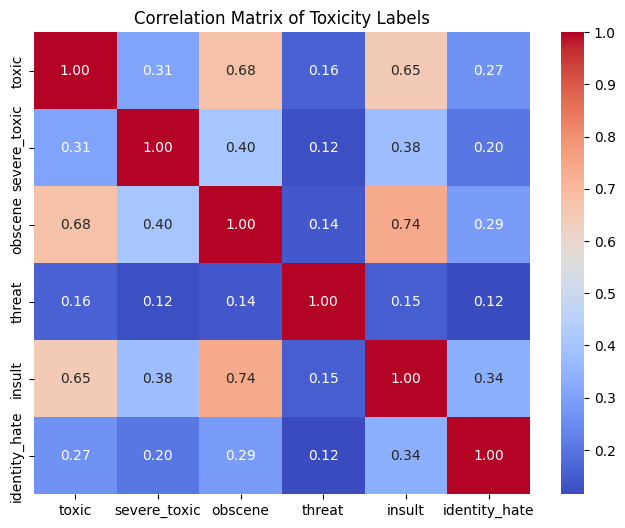

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[label_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Toxicity Labels')
plt.show()

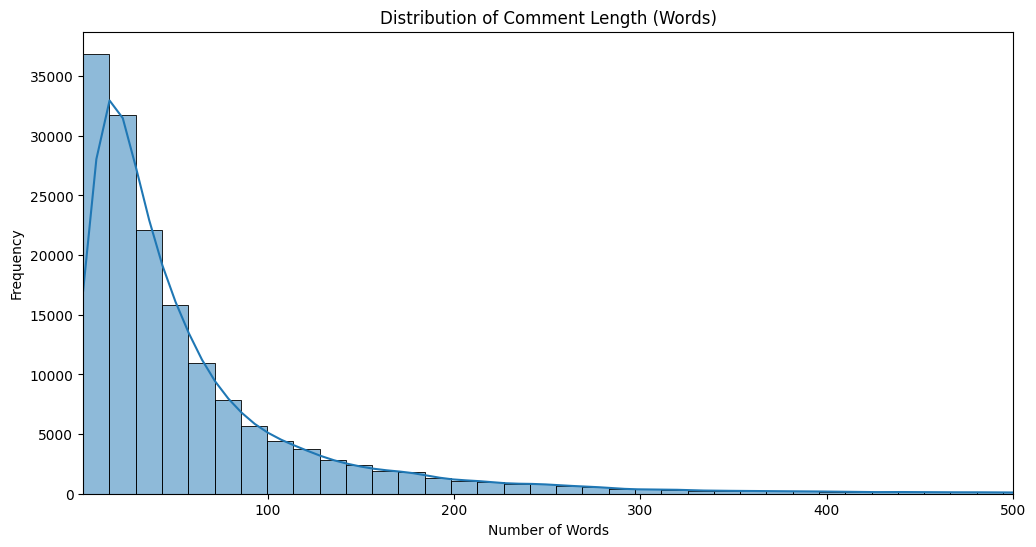

In [ ]:
train_df['comment_length'] = train_df['comment_text'].apply(lambda x: len(x.split()))
test_df['comment_length'] = test_df['comment_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(train_df['comment_length'], bins=100, kde=True)
plt.title('Distribution of Comment Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(1, 500)
plt.show()


In [ ]:
print("\nComment Length Statistics (Words):")
print(train_df['comment_length'].describe())


Comment Length Statistics (Words):
count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_length, dtype: float64


In [ ]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
train_df['comment_text_cleaned'] = train_df['comment_text']
test_df['comment_text_cleaned'] = test_df['comment_text']

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Example for tokenization
sample_text = "This is a sample comment for tokenization."
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

print("\nSample Tokenization:")
print(f"Text: {sample_text}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])}")
print(f"Input IDs: {tokens['input_ids']}")
print(f"Attention Mask: {tokens['attention_mask']}")



Sample Tokenization:
Text: This is a sample comment for tokenization.
Tokens: ['[CLS]', 'this', 'is', 'a', 'sample', 'comment', 'for', 'token', '##ization', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([[  101,  2023,  2003,  1037,  7099,  7615,  2005, 19204,  3989,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
class ToxicCommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
      """
        Initializes the dataset with text samples and labels.
        comments: array of cleaned comment strings.
        labels: multi-label array (shape: num_samples x num_labels).
        tokenizer: pre-loaded BERT tokenizer.
        max_len: maximum token length for padding/truncation.
        """
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)         # Returns the total number of samples

    def __getitem__(self, item):                     # Fetches a single sample and its labels
        comment = str(self.comments[item])
        target = self.labels[item]

        # Tokenize and encode the text to BERT input format
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.float)
        }

X = train_df['comment_text_cleaned'].values
y = train_df[label_cols].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,
    random_state=SEED,
)

print(f"\nTrain size: {len(X_train)}, Validation size: {len(X_val)}")



Train size: 143613, Validation size: 15958


In [ ]:
# Wrap data in custom dataset class for PyTorch
train_dataset = ToxicCommentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = ToxicCommentDataset(X_val, y_val, tokenizer, MAX_LENGTH)

# DataLoader handles batching, shuffling, and parallel loading
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
# Model Setup

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_cols),
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

print("\nModel loaded successfully.")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded successfully.


In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.BCEWithLogitsLoss().to(device)


AdamW Optimizer: Combines Adam’s adaptive updates with decoupled weight decay for better generalization.

Learning-Rate Scheduling: Total steps = batches × epochs; linear decay ensures gradual reduction of LR over training.

No Warm-up Phase: Starting at full LR; you could add warm-up steps if you see unstable initial gradients.

BCEWithLogitsLoss: Internally applies a sigmoid before binary cross-entropy—ideal for multi-label setups.

Device Placement: Ensures all model parameters and loss computations happen on the same (GPU/CPU) device for speed and correctness.

In [ ]:
# Training Epoch Function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    # Set model to training mode (activates dropout, etc.)
    model.train()
    total_loss = 0               # Initialize running loss for this epoch
    num_batches = len(data_loader)  # Total number of batches to process

    for i, batch in enumerate(data_loader):
        # Move inputs and labels to the computation device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass: compute model outputs (logits)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits

        # Compute loss between logits and ground-truth labels
        loss = loss_fn(logits, labels)
        total_loss += loss.item()  # Accumulate batch loss

        # Backward pass: compute gradients
        loss.backward()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model parameters and learning rate scheduler
        optimizer.step()
        scheduler.step()

        # Periodic logging to monitor training progress
        if (i + 1) % 100 == 0:
            print(f'  Batch {i + 1}/{num_batches} | Loss: {loss.item():.4f}')

    # Compute average loss over all batches
    avg_train_loss = total_loss / num_batches
    print(f" Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss

Ensure model.train() is called to enable training-specific layers like dropout.
optimizer.zero_grad() avoids gradient accumulation from previous batches.
loss.backward() computes gradients; then clip_grad_norm_ keeps them stable.
scheduler.step() adjusts learning rate after each batch.
Logging every 100 batches helps catch issues early and track progress.
Returning avg_train_loss provides a summary metric for the epoch.

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()
    total_loss = 0             # Initialize running loss for validation
    all_preds = []             # List to collect prediction probabilities
    all_labels = []            # List to collect true label vectors
    num_batches = len(data_loader)  # Total number of validation batches

    with torch.no_grad():      # No gradient computation for evaluation
        for batch in data_loader:
            # Move inputs and labels to the computation device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass: compute logits
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits

            # Compute batch loss and accumulate
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Calculate average validation loss
    avg_val_loss = total_loss / num_batches
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")

    # Concatenate all batches for metric computation
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Compute ROC AUC for each label and mean across labels
    roc_auc_scores = {}
    for i, label_name in enumerate(label_cols):
        if len(np.unique(all_labels[:, i])) > 1:
            roc_auc_scores[label_name] = roc_auc_score(all_labels[:, i], all_preds[:, i])
        else:
            roc_auc_scores[label_name] = np.nan  # Undefined when only one class present
    mean_roc_auc = np.nanmean(list(roc_auc_scores.values()))
    print(f"  Mean ROC AUC: {mean_roc_auc:.4f}")
    print("  Individual ROC AUC Scores:")
    for name, score in roc_auc_scores.items():
        print(f"    {name}: {score:.4f}")

    # Compute Hamming loss at default threshold of 0.5
    threshold = 0.5
    binary_preds = (all_preds > threshold).astype(int)
    hamming = hamming_loss(all_labels, binary_preds)
    print(f"  Hamming Loss: {hamming:.4f}")

    return avg_val_loss, mean_roc_auc, hamming


The `eval_model` function performs a full pass over the validation set without updating model weights.
It computes:
Average validation loss to monitor convergence.
Per-label and mean ROC AUC for multi-label performance assessment.
Hamming loss at a 0.5 threshold to measure exact match accuracy in multi-label predictions.
Returned metrics (`avg_val_loss`, `mean_roc_auc`, `hamming`) can be logged or plotted to compare validation performance across epochs.


In [ ]:
history = {'train_loss': [], 'val_loss': [], 'val_roc_auc': [], 'val_hamming': []}
best_roc_auc = -1
best_model_state = None

print("\nStarting Training...")
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )
    history['train_loss'].append(train_loss)

    print(f"\n--- Validation Epoch {epoch + 1} ---")
    val_loss, val_roc_auc, val_hamming = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device
    )
    history['val_loss'].append(val_loss)
    history['val_roc_auc'].append(val_roc_auc)
    history['val_hamming'].append(val_hamming)

    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model_state.bin')
        print(f"  ** New best model saved with ROC AUC: {best_roc_auc:.4f} **")

print("\nTraining Finished.")
print(f"Best Validation ROC AUC: {best_roc_auc:.4f}")



Starting Training...

--- Epoch 1/3 ---
  Batch 100/8976 | Loss: 0.2072
  Batch 200/8976 | Loss: 0.0870
  Batch 300/8976 | Loss: 0.0824
  Batch 400/8976 | Loss: 0.0334
  Batch 500/8976 | Loss: 0.0263
  Batch 600/8976 | Loss: 0.0303
  Batch 700/8976 | Loss: 0.0782
  Batch 800/8976 | Loss: 0.1094
  Batch 900/8976 | Loss: 0.1512
  Batch 1000/8976 | Loss: 0.0578
  Batch 1100/8976 | Loss: 0.0652
  Batch 1200/8976 | Loss: 0.0153
  Batch 1300/8976 | Loss: 0.0586
  Batch 1400/8976 | Loss: 0.1118
  Batch 1500/8976 | Loss: 0.0610
  Batch 1600/8976 | Loss: 0.0058
  Batch 1700/8976 | Loss: 0.0559
  Batch 1800/8976 | Loss: 0.0145
  Batch 1900/8976 | Loss: 0.0550
  Batch 2000/8976 | Loss: 0.0200
  Batch 2100/8976 | Loss: 0.0652
  Batch 2200/8976 | Loss: 0.0307
  Batch 2300/8976 | Loss: 0.0034
  Batch 2400/8976 | Loss: 0.0024
  Batch 2500/8976 | Loss: 0.0618
  Batch 2600/8976 | Loss: 0.0611
  Batch 2700/8976 | Loss: 0.0587
  Batch 2800/8976 | Loss: 0.0730
  Batch 2900/8976 | Loss: 0.0189
  Batch 300

Avg. Validation Loss (0.0416): on average, the model’s probability predictions are very close to the true labels (lower is better).

Mean ROC AUC (0.9913): across all six classes the model almost perfectly separates positives from negatives (1.0 is ideal).

Per-class ROC AUC: each label—with scores from 0.9860 to 0.9982—shows excellent discrimination, even for rare tags like “threat.”

Hamming Loss (0.0147): on average only ~1.5% of individual label assignments are incorrect per example, indicating very few false positives or false negatives.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

drive_save_dir = "/content/drive/MyDrive/bert_saved_model"
os.makedirs(drive_save_dir, exist_ok=True)

tokenizer.save_pretrained(drive_save_dir)
model.save_pretrained(drive_save_dir)
print(f"✅ Model and tokenizer saved to {drive_save_dir}")

Mounted at /content/drive
✅ Model and tokenizer saved to /content/drive/MyDrive/bert_saved_model


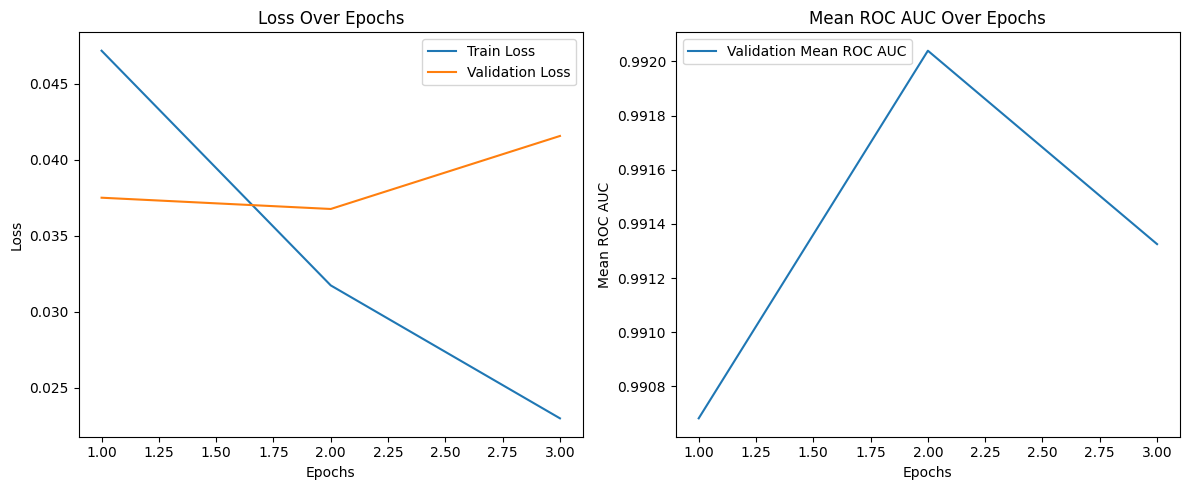

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, EPOCHS + 1), history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history['val_roc_auc'], label='Validation Mean ROC AUC')
plt.title('Mean ROC AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Training Results and Plot Description

After completing training over multiple epochs, the following trends were observed:

- **Training Loss** steadily decreases each epoch, indicating the model is fitting the training data more closely.
- **Validation Loss** dips slightly in the second epoch but rises in the third, suggesting a minor overfitting effect after epoch 2.
- **Mean ROC AUC** peaks at epoch 2 with a value above **0.9920**, demonstrating excellent discriminative power on unseen data. It slightly declines by epoch 3 but remains very high, confirming robust overall performance.

These plots together help identify the best epoch for checkpointing (epoch 2) and highlight the trade-off between further loss reduction on training data versus generalization on validation data.


In [8]:
#  Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load test data
import pandas as pd
test_path = '/content/drive/MyDrive/test1.csv'
test_df = pd.read_csv(test_path)
train_path = '/content/drive/MyDrive/train1.csv'
train_df = pd.read_csv(train_path)
texts   = test_df['comment_text'].fillna('').tolist()

# Reload model & tokenizer
import torch, numpy as np
from transformers import BertForSequenceClassification, BertTokenizer

drive_save_dir = '/content/drive/MyDrive/bert_saved_model'
model     = BertForSequenceClassification.from_pretrained(drive_save_dir, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(drive_save_dir, local_files_only=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

label_cols = [
    "toxic", "severe_toxic", "obscene",
    "threat", "insult", "identity_hate"
]


Mounted at /content/drive


'def predict(text, threshold=0.5):\n    #  Tokenize to CPU tensors\n    inputs = tokenizer(\n        text,\n        max_length=128,\n        padding="max_length",\n        truncation=True,\n        return_tensors="pt"\n    )\n    #  Move every tensor to the model’s device\n    inputs = {k: v.to(device) for k, v in inputs.items()}\n\n    # Inference\n    with torch.no_grad():\n        logits = model(**inputs).logits\n\n    #  Convert to probs & preds\n    probs = torch.sigmoid(logits).cpu().numpy()[0]\n    preds = (probs >= threshold).astype(int)\n\n    #  Return paired dicts\n    return dict(zip(label_cols, probs)), dict(zip(label_cols, preds))'

In [7]:
def predict(text, threshold=0.5):
    # tokenize → CPU tensors
    inputs = tokenizer(
        text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    # move them to GPU if model is on GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # forward pass
    with torch.no_grad():
        logits = model(**inputs).logits

    # to probabilities, then CPU numpy
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    preds = (probs >= threshold).astype(int)

    # dicts for convenience
    prob_dict = dict(zip(label_cols, probs))
    pred_dict = dict(zip(label_cols, preds.tolist()))
    return prob_dict, pred_dict


In [14]:

!pip install --quiet gradio

import gradio as gr

def infer_gradio(text, threshold=0.5):
    # Get both probabilities and binary preds
    prob_dict, pred_dict = predict(text, threshold)

    # If no toxic label is predicted, return only non_toxic at 100%
    if all(v == 0 for v in pred_dict.values()):
        return {"non_toxic": 1.0}

    # Otherwise, show all six toxic‐label probabilities
    return {label: float(prob_dict[label]) for label in label_cols}

#  Built interface
iface = gr.Interface(
    fn=infer_gradio,
    inputs=[
        gr.Textbox(lines=3, placeholder="Enter text here...", label="Comment"),
        gr.Slider(minimum=0, maximum=1, step=0.05, value=0.5, label="Threshold")
    ],
    outputs=gr.Label(num_top_classes=len(label_cols) + 1),
    title="BERT Toxic Comment Classifier",
    description="Enter a comment to see toxicity probabilities."
)

#  Launch
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a7b66c112ffb68fb98.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
